# CNNs in PyTorch

This notebook shows how to implement CNNs using PyTorch.

We will start by looking at DataLoaders, a PyTorch way of organizing datasets in an easy way. 

# 0. Imports, Constants and Support Functions

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
CONFIG = {
    "train_dataset": "../Datasets/seg_train/seg_train/",
    "test_dataset": "../Datasets/seg_test/seg_test/",
    "batch_size": 32,
}

# 1. Load and preprocess the dataset

When working with images, pre-processing steps need to be applied to ensure our AI model can make sense of it.
For this purpose, we will use:
- The support class `Compose` to create the preprocessing steps
- The support class `ImageFolder` to point to the folder and the transformation required for this dataset.
- The function `random_split` to divide the training dataset into train and validation.
- The support class `DataLoader` to divide the data into batches to load in memory, shuffles it, and provides to the model.

In [3]:
# Define preprocessing steps
preprocessing_pipeline = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalization based on the literature
    ]
)

In [4]:
# Load datasets
train_dataset = datasets.ImageFolder(
    root=CONFIG["train_dataset"], transform=preprocessing_pipeline
)
test_dataset = datasets.ImageFolder(
    root=CONFIG["test_dataset"], transform=preprocessing_pipeline
)

# Generate validation dataset
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Use DataLoader to load the images when supplying it to the model
train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

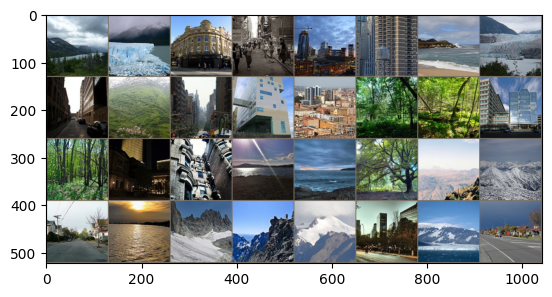

In [5]:
# Function to visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# 2. Implement a Convolutional Neural Network

Convolutional Neural Network, or CNN, are the backbone of Computer Vision algorithms. We can implement them in PyTorch using `torchvision` library.

This architecture is based on the following elements:
- **Convolutional Layers**: Apply a convolutional mask to the image to extract features.
- **Activation Functions**: Introduce non-linearity into the model.
- **Pooling Layers**: Reduce the spatial dimension of the feature map.

In [6]:
class BasicCNN(nn.Module):
    def __init__(self) -> None:
        super(BasicCNN, self).__init__()

        # Define layers
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 128 * 128, out_features=6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

In [7]:
# Instantiate class
cnn_model = BasicCNN()

# Define devices
device = torch.device("cpu")
cnn_model.to(device)

# Define training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 5

In [8]:
# Set the model in training mode
cnn_model.train()

# Define training loop
for epoch in range(num_epochs):
    # Start logging on each iteration
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        # Move to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        prediction = cnn_model(inputs)

        # Calculate loss
        loss = criterion(prediction, labels)

        # Reset gradient after each iteration
        optimizer.zero_grad()  # This needs to be done on each batch!

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

100%|██████████| 395/395 [00:34<00:00, 11.30it/s]


Epoch [1/5], Loss: 3.3377


100%|██████████| 395/395 [00:33<00:00, 11.69it/s]


Epoch [2/5], Loss: 0.8615


100%|██████████| 395/395 [00:33<00:00, 11.65it/s]


Epoch [3/5], Loss: 0.0351


100%|██████████| 395/395 [00:33<00:00, 11.70it/s]


Epoch [4/5], Loss: 0.0368


100%|██████████| 395/395 [00:33<00:00, 11.73it/s]

Epoch [5/5], Loss: 0.1294
